In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utils import rollout, discount_rewards, generate_cubes, generate_random_cuboids
from environment import ThreeDimBin
from model import PackingModel
from optimizer import PPOTrainer


In [2]:
# Setup
LENGTH = 30
WIDTH = 30
HEIGHT = 50
objects = generate_random_cuboids(25,([2,3],[3,4],[4,5]))
DEVICE = "cuda"  # todo run on colab to check if runnning on gpu works as it should
n_episodes = 1000
print_freq = 10
batch_size = 32

In [3]:
env = ThreeDimBin(LENGTH, WIDTH, HEIGHT, objects)

model = PackingModel(num_samples=50, embedding_dim=128, num_heads=8, num_layers=4)
model = model.to(DEVICE)

ppo = PPOTrainer(model,
                 policy_lr=3e-4,
                 value_lr=1e-3,
                 target_kl_div=0.02,
                 max_policy_train_iters=40,
                 value_train_iters=40)

In [4]:
# Training loop
ep_rewards = []
ep_density = []
for episode_idx in range(n_episodes):
    # Perform rollout
    train_data, reward = rollout(model, env, device=DEVICE)  # todo run a different set of random objects on each loop
    ep_rewards.append(reward)
    ep_density.append(env.calc_reward())

    # Shuffle
    permute_idxs = np.random.permutation(len(train_data[0]))
    
    
    def adjust_data_and_train(indeces):
        # Policy data
        obs = []  # the training method is expecting a list of batched bin and object states
        for j in range(train_data[0].shape[1]):
            obs.append(torch.stack(list(train_data[0][indeces, j]), dim=1).squeeze(0).to(DEVICE))

        # change it to a tensor of shape (batch, 7) instead of an array of nested tuples
        acts = [torch.tensor(list(train_data[1][indeces, 0])),
                torch.tensor(list(zip(*train_data[1][indeces, 1]))[0]),
                torch.tensor(list(zip(*train_data[1][indeces, 1]))[1]),
                torch.tensor(list(zip(*train_data[1][indeces, 1]))[2]),
                torch.tensor(list(zip(*train_data[1][indeces, 2]))[0]),
                torch.tensor(list(zip(*train_data[1][indeces, 2]))[1]),
                torch.tensor(list(zip(*train_data[1][indeces, 2]))[2])]
        acts = torch.stack(acts, dim=1).to(DEVICE)
        gaes = torch.tensor(train_data[3][indeces], device=DEVICE)  # .to(torch.float32)
        act_log_probs = torch.tensor(train_data[4][indeces], device=DEVICE)  # .to(torch.float32)

        # Value data
        returns = discount_rewards(train_data[2])[indeces]
        returns = torch.tensor(returns, device=DEVICE)  # .to(torch.float32)

        # Train model
        ppo.train_policy(obs, acts, act_log_probs, gaes, (LENGTH, WIDTH, HEIGHT), DEVICE)
        ppo.train_value(obs, returns)


    if train_data[0].shape[0] > batch_size:
        for i in range(batch_size, train_data[0].shape[0], batch_size):
            adjust_data_and_train(permute_idxs[i-batch_size:i])
    else:
        adjust_data_and_train(permute_idxs)

    if (episode_idx + 1) % print_freq == 0:
        print('Episode {} | Avg Reward {:.2f} | Avg Density {:.2f}'.format(
            episode_idx + 1, np.mean(ep_rewards[-print_freq:]), np.mean(ep_density[-print_freq:])))


/content/utils.py:153: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  train_data = [np.asarray(x) for x in train_data]
/content/utils.py:153: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_data = [np.asarray(x) for x in train_data]


Episode 10 | Avg Reward -113.20 | Avg Density 0.04
Episode 20 | Avg Reward -8.91 | Avg Density 0.03
Episode 30 | Avg Reward -4.39 | Avg Density 0.03
Episode 40 | Avg Reward -8.60 | Avg Density 0.03
Episode 50 | Avg Reward -7.03 | Avg Density 0.03
Episode 60 | Avg Reward -8.61 | Avg Density 0.03
Episode 70 | Avg Reward -14.51 | Avg Density 0.03
Episode 80 | Avg Reward -11.17 | Avg Density 0.04
Episode 90 | Avg Reward -20.62 | Avg Density 0.03
Episode 100 | Avg Reward -18.24 | Avg Density 0.04
Episode 110 | Avg Reward -13.30 | Avg Density 0.03
Episode 120 | Avg Reward -18.89 | Avg Density 0.03
Episode 130 | Avg Reward -20.47 | Avg Density 0.03
Episode 140 | Avg Reward -17.96 | Avg Density 0.05
Episode 150 | Avg Reward -12.41 | Avg Density 0.03
Episode 160 | Avg Reward -29.21 | Avg Density 0.04
Episode 170 | Avg Reward -111.83 | Avg Density 0.04
Episode 180 | Avg Reward -69.10 | Avg Density 0.03
Episode 190 | Avg Reward -11.38 | Avg Density 0.03
Episode 200 | Avg Reward -12.15 | Avg Densi

KeyboardInterrupt: ignored

Text(0, 0.5, 'packing density')

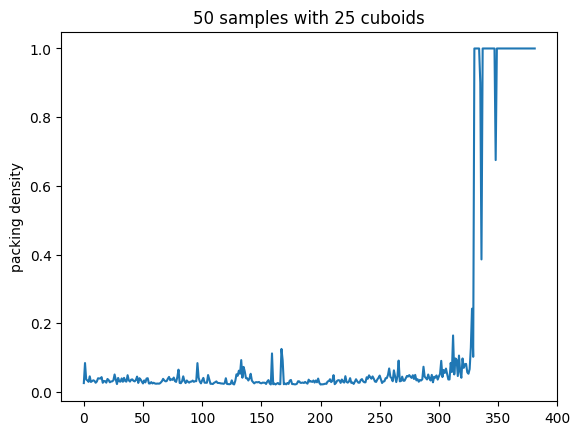

In [5]:
plt.plot(ep_density)
plt.title("50 samples with 25 cuboids")
plt.ylabel("packing density")
# plt.ylim([-10, 2])